In [3]:
#Imports
import torch
import numpy as np
from itertools import permutations
from itertools import product
import matplotlib.pyplot as plt

In [12]:
def fidelity_ml(J,B,M,target_gate,t,N_iter):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex
    """
    
    #Pauli Matricies 
    sx = np.array([[0, 1], [1, 0]])
    sy = np.array([[0,-1j],[1j,0]])
    sz = np.array([[1, 0], [0, -1]])
    id = np.array([[1,0],[0,1]])
    
    #Function definitions 
    def zero_mat(N):#Generates matrix of zeros
        zero_gate = np.array([[0,0],[0,0]])
        init = np.array([[0,0],[0,0]])
        if N < 2:
            return 1
        for i in range(0,N - 1):
            zero_gate = torch.tensor(np.kron(zero_gate,init))
        return zero_gate
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        N = len(coef)#number of qubits
        total_pauli = zero_mat(N)
        #Summing all Z gates
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = len(B)
    torch.manual_seed(9)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #J coefficients gathering (only if J is in N x N matrix, otherwise set J_coef=J)
    J_coef = []
    for i in range(0,len(J) - 1):
        for j in range(0,len(J) - i - 1):
            J_coef.append(J[i,j].item())

    #H0 generation
    permuts = [1,1]
    for i in range(2,N):
        permuts.append(0)
    permuts = list(set(permutations(permuts,N)))
    permuts.sort()
    permuts.reverse()#All permutations of ZZ coupling stored as bit arrays
    H0 = zero_mat(N)
    for i,u in enumerate(permuts):#summing ZZ permutations and J constants
        ZZ_temp = 1
        for p in u:
            if p==1:
                ZZ_temp = torch.tensor(np.kron(ZZ_temp,sz))
            else:
                ZZ_temp = torch.tensor(np.kron(ZZ_temp,id))
        H0 = H0 + J_coef[i]*ZZ_temp

    H0 = H0 + sum_pauli(B,sz)

    #Unitary group generation
    SU = []
    pauli_int = [1, 2, 3, 4]#eq to [sx,sy,sz,id]
    perms = list(product(pauli_int,repeat=N))#all permutations of paulis
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1:
                unitary = torch.tensor(np.kron(unitary,sx),dtype=torch.cdouble)
            elif pauli == 2:
                unitary = torch.tensor(np.kron(unitary,sy),dtype=torch.cdouble)
            elif pauli == 3:
                unitary = torch.tensor(np.kron(unitary,sz),dtype=torch.cdouble)
            elif pauli == 4:
                unitary = torch.tensor(np.kron(unitary,id),dtype=torch.cdouble)
        SU.append(unitary)

    #These are the coefficients we are optimizing
    R = torch.rand([M,2*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate

    #Optimizer settings(can be changed & opttimized)
    lr=0.3#learning rate

    opt = 'SGD'  # Choose optimizer - ADAM, SGD (typical). ADAMW, ADAMax, Adadelta,  
                        # Adagrad, Rprop, RMSprop, ASGD, also valid options.     
    sched = 'Plateau'  # Choose learning rate scheduler - Plateau, Exponential (typical), Step
    
    if opt=='ADAM': optimizer = torch.optim.Adam([R], lr = lr, weight_decay=1e-6)
    elif opt=='ADAMW': optimizer = torch.optim.AdamW([R], lr = lr, weight_decay=0.01)
    elif opt=='ADAMax': optimizer = torch.optim.Adamax([R], lr = lr, weight_decay=0.01)
    elif opt=='RMSprop': optimizer = torch.optim.RMSprop([R], lr = lr, momentum=0.2)
    elif opt=='Rprop': optimizer = torch.optim.Rprop([R], lr = lr)
    elif opt=='Adadelta': optimizer = torch.optim.Adadelta([R], lr = lr) 
    elif opt=='Adagrad': optimizer = torch.optim.Adagrad([R], lr = lr)
    elif opt=='SGD': optimizer = torch.optim.SGD([R], lr = lr, momentum=0.99, nesterov=True)
    elif opt=='ASGD': optimizer = torch.optim.ASGD([R], lr = lr)
    else: optimizer=None; opt='None'
        
    if sched=='Step': scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=N_iter/10, gamma=0.9)
    elif sched=='Exponential': scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    elif sched=='Plateau': scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 ); loss_in=True; 
    else: scheduler=None; sched='None'

    for n in range(0,N_iter):
        #Creating Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:],sy)
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 2**N
        for i in range(0,len(SU)):
            eps_U = torch.matmul(torch.matmul(U_Exp,SU[i]),(U_Exp.conj().T))
            target_U = torch.matmul(torch.matmul(target_gate,(SU[i].conj().T)),(target_gate.conj().T))
            tr = torch.trace(torch.matmul(target_U,eps_U))
            fidelity = fidelity + tr
        fidelity = abs(fidelity + d*d)/(d*d*(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        #if (n+1)%20==0: 
            #print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        if optimizer is not None and scheduler is None:  # Update R
            optimizer.step()
            optimizer.zero_grad()
        elif optimizer is not None and scheduler is not None:
            optimizer.step()
            if loss_in: 
                scheduler.step(infidelity)
            else: 
                scheduler.step()
            optimizer.zero_grad()
        else:
            R.data.sub_(lr*R.grad.data) # using data avoids overwriting tensor object
            R.grad.data.zero_()           # and it's respective grad info
    
    #print('The infidelity of the generated gate is: ' + str(infidelity_list.min().item()))
    #return R
    return infidelity_list.min().item()

In [5]:
#Testing fidelity function
#2 qubit gates (works great :) )
target_gates =[torch.tensor((1/np.sqrt(2))*np.kron(np.array([[1,-1j],[-1j,1]]),np.eye(2)),dtype=torch.cdouble),
                torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]], dtype=torch.cdouble),
                torch.tensor([[1,0,0,0],[0, 0, 1j, 0], [0, 1j,0,0],[0,0,0,1]], dtype=torch.cdouble),
                torch.tensor([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=torch.cdouble),
                torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]], dtype=torch.cdouble)]
#3 qubit gates (works great as well!!)
toffoli = torch.tensor([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1],[0,0,0,0,0,0,1,0]],dtype=torch.cdouble)
J = torch.tensor([[1,1,1],[1,1,1],[1,1,1]])
Coef = fidelity_ml(J,[1,1,1],12,toffoli,np.pi,300)

Itertation  20  out of  300 complete. Avg Infidelity:  0.6765755025850978
Itertation  40  out of  300 complete. Avg Infidelity:  0.5039254614305635
Itertation  60  out of  300 complete. Avg Infidelity:  0.3812421860361571
Itertation  80  out of  300 complete. Avg Infidelity:  0.29692646170345716
Itertation  100  out of  300 complete. Avg Infidelity:  0.1871049063752035
Itertation  120  out of  300 complete. Avg Infidelity:  0.17952466768011888
Itertation  140  out of  300 complete. Avg Infidelity:  0.15514119558636097
Itertation  160  out of  300 complete. Avg Infidelity:  0.12417304791456396
Itertation  180  out of  300 complete. Avg Infidelity:  0.09940407416367725
Itertation  200  out of  300 complete. Avg Infidelity:  0.08800491410036315
Itertation  220  out of  300 complete. Avg Infidelity:  0.07562680429330326
Itertation  240  out of  300 complete. Avg Infidelity:  0.06603357882436789
Itertation  260  out of  300 complete. Avg Infidelity:  0.05632273093172735
Itertation  280  out

Text(0.5, 1.0, '2 Qubit CNOT Fidelity for ZZ coupled H0')

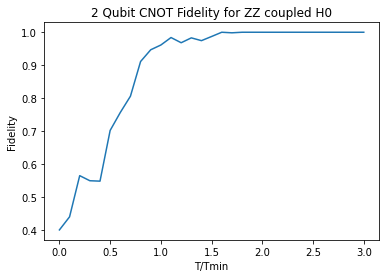

In [28]:
#graph generation
CNOT = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])

Fidelities = []
Times = []
for i in range(0,31):
    Times.append(i/10)
    Fidelities.append(1 - fidelity_ml(J,[1,1],16,CNOT,i/10*np.pi/4,1000))

plt.plot(Times,Fidelities)
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("2 Qubit CNOT Fidelity for ZZ coupled H0")

In [26]:
CNOT = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype=torch.cdouble)
1 - fidelity_ml(J,[1,1],16,CNOT,0,300)

0.3999999761581421

In [24]:
np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])